# Categorical Data Evaluation

Stepping back from the priority model to just consider the input and target data for our training.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras import regularizers
from keras import metrics
from keras import backend as kerasbackend
from collections import Counter
import time
import matplotlib.colors as colors
import scipy.stats as ss
import seaborn
import math
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


### Load data from saved joblib file

In [2]:
wr_archive = 'work_requests_train.joblib'
print("Loading data from", wr_archive, "...")
work_requests_train = joblib.load(wr_archive)
wr_archive = 'work_requests_validation.joblib'
print("Loading data from", wr_archive, "...")
work_requests_val = joblib.load(wr_archive)

Loading data from work_requests_train.joblib ...
Loading data from work_requests_validation.joblib ...


In [3]:
work_requests_train.shape

(47645, 60)

### Create final columns for prediction combining WR and WO data

In [4]:
work_requests_train["Target_Priority"] = work_requests_train.apply(lambda row: 
                                             row["WO_Priority"] if row["WO_Priority"]
                                             else row["Priority"]
                                            , axis=1)
work_requests_train["Target_Outage_Ind"] = work_requests_train.apply(lambda row: 
                                             row["WO_Outage_Ind"] if row["WO_Outage_Ind"]
                                             else row["Outage_Ind"]
                                            , axis=1)
work_requests_train["Target_Discipline"] = work_requests_train.apply(lambda row: 
                                             row["WO_Discipline"] if row["WO_Discipline"]
                                             else row["Discipline"]
                                            , axis=1)
work_requests_train["Target_Job_Type"] = work_requests_train["Job_Type"]

work_requests_val["Target_Priority"] = work_requests_val.apply(lambda row: 
                                             row["WO_Priority"] if row["WO_Priority"]
                                             else row["Priority"]
                                            , axis=1)
work_requests_val["Target_Outage_Ind"] = work_requests_val.apply(lambda row: 
                                             row["WO_Outage_Ind"] if row["WO_Outage_Ind"]
                                             else row["Outage_Ind"]
                                            , axis=1)
work_requests_val["Target_Discipline"] = work_requests_val.apply(lambda row: 
                                             row["WO_Discipline"] if row["WO_Discipline"]
                                             else row["Discipline"]
                                            , axis=1)
work_requests_val["Target_Job_Type"] = work_requests_val["Job_Type"]

Select a subset of the entries in the dataframe for which we will calculate the confusion matrix and do statistics.

In [5]:
remove_list = ("Priority", "Job_Type", "Outage_Ind", "Discipline", "WO_Priority", "WO_Outage_Ind", "WO_Discipline")
cats_to_analyze = list(np.append(np.array(list(work_requests_train))[(work_requests_train.nunique() < 100) & (work_requests_train.nunique() > 0) & (work_requests_train.notna().sum() > 1000)],
                            ("Equipment_Type", "System_Code")))
for rem_item in remove_list:
    cats_to_analyze.remove(rem_item)

In [6]:
print(cats_to_analyze)

['Facility', 'Unit', 'Work_Against_Code', 'Outage', 'WR_Status', 'Work_Status', 'Trouble_Brkdwn', 'Ops_Review', 'U_Code', 'Equip_Revision', 'Equip_Group_Type', 'Component_Type', 'Location_Region', 'Equip_Class', 'Unit_Condition_Required', 'Nuc_Applicable_Mode', 'FID', 'SPV', 'MRULE', 'IST', 'CDA', 'SAFE_SD', 'E_PLAN', 'LIC_RENEW', 'Related_Action', 'Related_WO_Task', 'Target_Priority', 'Target_Outage_Ind', 'Target_Discipline', 'Target_Job_Type', 'Equipment_Type', 'System_Code']


We can try using the Cramers V function, found at:
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [113]:
def cramers_v(x, y): 
    """ 
    Calculates Cramer's V statistic for categorical-categorical association. 
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328. 
    This is a symmetric coefficient: V(x,y) = V(y,x) 
 
    Original function taken from: https://stackoverflow.com/a/46498792/5863503 
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V 
 
    :param x: list / NumPy ndarray / Pandas Series 
        A sequence of categorical measurements 
    :param y: list / NumPy ndarray / Pandas Series 
        A sequence of categorical measurements 
    :return: float 
        in the range of [0,1] 
    """ 
    confusion_matrix = pd.crosstab(x,y) 
    if not confusion_matrix.size:
        return -1
    chi2 = ss.chi2_contingency(confusion_matrix)[0] 
    n = confusion_matrix.sum().sum() 
    phi2 = chi2/n 
    r,k = confusion_matrix.shape 
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1)) 
    rcorr = r-((r-1)**2)/(n-1) 
    kcorr = k-((k-1)**2)/(n-1) 
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))) 

In [114]:
cramers_v(work_requests_train["Equipment_Type"], work_requests_train["Discipline"])

0.23005298041831315

In [115]:
work_requests_train.shape

(47645, 65)

In [116]:
correlation_df = pd.DataFrame(index=cats_to_analyze, columns=cats_to_analyze)
print(correlation_df.shape)

(32, 32)


In [117]:
for i, icat in enumerate(cats_to_analyze):
    for j, jcat in enumerate(cats_to_analyze):
        print("Now testing", icat, jcat)
        correlation_df[icat][jcat] = cramers_v(work_requests_train[icat], work_requests_train[jcat])

Now testing Facility Facility
Now testing Facility Unit
Now testing Facility Work_Against_Code
Now testing Facility Outage
Now testing Facility WR_Status
Now testing Facility Work_Status
Now testing Facility Trouble_Brkdwn
Now testing Facility Ops_Review
Now testing Facility U_Code
Now testing Facility Equip_Revision
Now testing Facility Equip_Group_Type
Now testing Facility Component_Type
Now testing Facility Location_Region
Now testing Facility Equip_Class
Now testing Facility Unit_Condition_Required
Now testing Facility Nuc_Applicable_Mode
Now testing Facility FID
Now testing Facility SPV
Now testing Facility MRULE
Now testing Facility IST
Now testing Facility CDA
Now testing Facility SAFE_SD
Now testing Facility E_PLAN
Now testing Facility LIC_RENEW
Now testing Facility Related_Action
Now testing Facility Related_WO_Task
Now testing Facility Target_Priority
Now testing Facility Target_Outage_Ind
Now testing Facility Target_Discipline
Now testing Facility Target_Job_Type
Now testing

/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


Now testing Work_Against_Code FID
Now testing Work_Against_Code SPV
Now testing Work_Against_Code MRULE
Now testing Work_Against_Code IST
Now testing Work_Against_Code CDA
Now testing Work_Against_Code SAFE_SD
Now testing Work_Against_Code E_PLAN
Now testing Work_Against_Code LIC_RENEW
Now testing Work_Against_Code Related_Action
Now testing Work_Against_Code Related_WO_Task
Now testing Work_Against_Code Target_Priority
Now testing Work_Against_Code Target_Outage_Ind
Now testing Work_Against_Code Target_Discipline
Now testing Work_Against_Code Target_Job_Type
Now testing Work_Against_Code Equipment_Type
Now testing Work_Against_Code System_Code
Now testing Outage Facility
Now testing Outage Unit
Now testing Outage Work_Against_Code
Now testing Outage Outage
Now testing Outage WR_Status
Now testing Outage Work_Status
Now testing Outage Trouble_Brkdwn
Now testing Outage Ops_Review
Now testing Outage U_Code
Now testing Outage Equip_Revision
Now testing Outage Equip_Group_Type
Now testing 

Now testing Equip_Revision Target_Job_Type
Now testing Equip_Revision Equipment_Type
Now testing Equip_Revision System_Code
Now testing Equip_Group_Type Facility
Now testing Equip_Group_Type Unit
Now testing Equip_Group_Type Work_Against_Code
Now testing Equip_Group_Type Outage
Now testing Equip_Group_Type WR_Status
Now testing Equip_Group_Type Work_Status
Now testing Equip_Group_Type Trouble_Brkdwn
Now testing Equip_Group_Type Ops_Review
Now testing Equip_Group_Type U_Code
Now testing Equip_Group_Type Equip_Revision
Now testing Equip_Group_Type Equip_Group_Type
Now testing Equip_Group_Type Component_Type
Now testing Equip_Group_Type Location_Region
Now testing Equip_Group_Type Equip_Class
Now testing Equip_Group_Type Unit_Condition_Required
Now testing Equip_Group_Type Nuc_Applicable_Mode
Now testing Equip_Group_Type FID
Now testing Equip_Group_Type SPV
Now testing Equip_Group_Type MRULE
Now testing Equip_Group_Type IST
Now testing Equip_Group_Type CDA
Now testing Equip_Group_Type SAF

/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars
/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


Now testing Equip_Class Related_WO_Task
Now testing Equip_Class Target_Priority
Now testing Equip_Class Target_Outage_Ind
Now testing Equip_Class Target_Discipline
Now testing Equip_Class Target_Job_Type
Now testing Equip_Class Equipment_Type
Now testing Equip_Class System_Code
Now testing Unit_Condition_Required Facility
Now testing Unit_Condition_Required Unit
Now testing Unit_Condition_Required Work_Against_Code
Now testing Unit_Condition_Required Outage
Now testing Unit_Condition_Required WR_Status
Now testing Unit_Condition_Required Work_Status
Now testing Unit_Condition_Required Trouble_Brkdwn
Now testing Unit_Condition_Required Ops_Review
Now testing Unit_Condition_Required U_Code
Now testing Unit_Condition_Required Equip_Revision
Now testing Unit_Condition_Required Equip_Group_Type
Now testing Unit_Condition_Required Component_Type
Now testing Unit_Condition_Required Location_Region
Now testing Unit_Condition_Required Equip_Class
Now testing Unit_Condition_Required Unit_Conditi

Now testing SAFE_SD SPV
Now testing SAFE_SD MRULE
Now testing SAFE_SD IST
Now testing SAFE_SD CDA
Now testing SAFE_SD SAFE_SD
Now testing SAFE_SD E_PLAN
Now testing SAFE_SD LIC_RENEW
Now testing SAFE_SD Related_Action
Now testing SAFE_SD Related_WO_Task
Now testing SAFE_SD Target_Priority
Now testing SAFE_SD Target_Outage_Ind
Now testing SAFE_SD Target_Discipline
Now testing SAFE_SD Target_Job_Type
Now testing SAFE_SD Equipment_Type
Now testing SAFE_SD System_Code
Now testing E_PLAN Facility
Now testing E_PLAN Unit
Now testing E_PLAN Work_Against_Code
Now testing E_PLAN Outage
Now testing E_PLAN WR_Status
Now testing E_PLAN Work_Status
Now testing E_PLAN Trouble_Brkdwn
Now testing E_PLAN Ops_Review
Now testing E_PLAN U_Code
Now testing E_PLAN Equip_Revision
Now testing E_PLAN Equip_Group_Type
Now testing E_PLAN Component_Type
Now testing E_PLAN Location_Region
Now testing E_PLAN Equip_Class
Now testing E_PLAN Unit_Condition_Required
Now testing E_PLAN Nuc_Applicable_Mode
Now testing E_

Now testing Target_Discipline Unit_Condition_Required
Now testing Target_Discipline Nuc_Applicable_Mode
Now testing Target_Discipline FID
Now testing Target_Discipline SPV
Now testing Target_Discipline MRULE
Now testing Target_Discipline IST
Now testing Target_Discipline CDA
Now testing Target_Discipline SAFE_SD
Now testing Target_Discipline E_PLAN
Now testing Target_Discipline LIC_RENEW
Now testing Target_Discipline Related_Action
Now testing Target_Discipline Related_WO_Task
Now testing Target_Discipline Target_Priority
Now testing Target_Discipline Target_Outage_Ind
Now testing Target_Discipline Target_Discipline
Now testing Target_Discipline Target_Job_Type
Now testing Target_Discipline Equipment_Type
Now testing Target_Discipline System_Code
Now testing Target_Job_Type Facility
Now testing Target_Job_Type Unit
Now testing Target_Job_Type Work_Against_Code
Now testing Target_Job_Type Outage
Now testing Target_Job_Type WR_Status
Now testing Target_Job_Type Work_Status
Now testing Ta

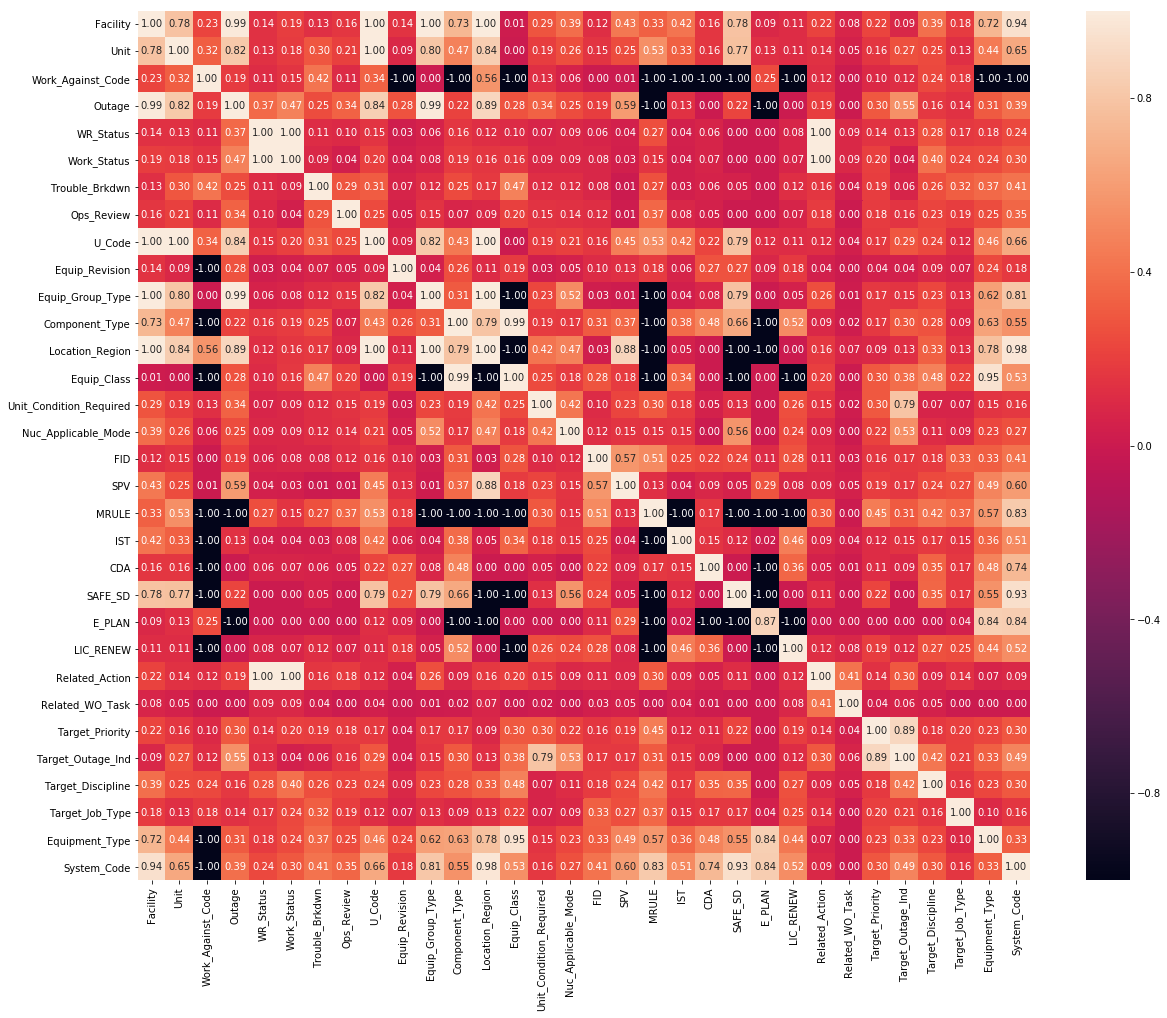

In [118]:
plt.figure(figsize=(20,16))
seaborn.heatmap(correlation_df.fillna(value=-1), annot=True, fmt=".2f")

Now let's use the Theil U, from the same online source.  I slightly modified it to drop all the nulls.

In [119]:
def conditional_entropy(x, y): 
    """ 
    Calculates the conditional entropy of x given y: S(x|y) 
  
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy 
  
    :param x: list / NumPy ndarray / Pandas Series 
        A sequence of measurements 
    :param y: list / NumPy ndarray / Pandas Series 
        A sequence of measurements 
    :return: float 
    """ 
    # entropy of x given y 
    y_counter = Counter(y) 
    xy_counter = Counter(list(zip(x,y))) 
    total_occurrences = sum(y_counter.values()) 
    entropy = 0.0 
    for xy in xy_counter.keys(): 
        p_xy = xy_counter[xy] / total_occurrences 
        p_y = y_counter[xy[1]] / total_occurrences 
        entropy += p_xy * math.log(p_y/p_xy) 
    return entropy 


In [120]:
def theils_u(x, y): 
    """ 
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association. 
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about 
    x, and 1 means y provides full information about x. 
    This is an asymmetric coefficient: U(x,y) != U(y,x) 
 
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient 
 
    :param x: list / NumPy ndarray / Pandas Series 
        A sequence of categorical measurements 
    :param y: list / NumPy ndarray / Pandas Series 
        A sequence of categorical measurements 
    :return: float 
        in the range of [0,1] 
    """ 
    # First, we'll put these together to drop all na values
    xy_frame = pd.concat([x,y], axis=1)
    xy_frame.dropna(axis=0, how='any', inplace=True)
    xp = xy_frame.iloc[:,0]
    yp = xy_frame.iloc[:,1]
    # Now do calculations
    s_xy = conditional_entropy(xp,yp) 
    x_counter = Counter(xp) 
    total_occurrences = sum(x_counter.values()) 
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values())) 
    s_x = ss.entropy(p_x) 
    if s_x == 0: 
        return 1 
    else: 
        return (s_x - s_xy) / s_x 


In [121]:
correlation_df2 = pd.DataFrame(index=cats_to_analyze, columns=cats_to_analyze)
print(correlation_df2.shape)

(32, 32)


In [122]:
for i, icat in enumerate(cats_to_analyze):
    for j, jcat in enumerate(cats_to_analyze):
        print("Now testing", icat, jcat)
        correlation_df2[icat][jcat] = theils_u(work_requests_train[icat], work_requests_train[jcat])

Now testing Facility Facility
Now testing Facility Unit
Now testing Facility Work_Against_Code
Now testing Facility Outage
Now testing Facility WR_Status
Now testing Facility Work_Status
Now testing Facility Trouble_Brkdwn
Now testing Facility Ops_Review
Now testing Facility U_Code
Now testing Facility Equip_Revision
Now testing Facility Equip_Group_Type
Now testing Facility Component_Type
Now testing Facility Location_Region
Now testing Facility Equip_Class
Now testing Facility Unit_Condition_Required
Now testing Facility Nuc_Applicable_Mode
Now testing Facility FID
Now testing Facility SPV
Now testing Facility MRULE
Now testing Facility IST
Now testing Facility CDA
Now testing Facility SAFE_SD
Now testing Facility E_PLAN
Now testing Facility LIC_RENEW
Now testing Facility Related_Action
Now testing Facility Related_WO_Task
Now testing Facility Target_Priority
Now testing Facility Target_Outage_Ind
Now testing Facility Target_Discipline
Now testing Facility Target_Job_Type
Now testing

Now testing Unit_Condition_Required WR_Status
Now testing Unit_Condition_Required Work_Status
Now testing Unit_Condition_Required Trouble_Brkdwn
Now testing Unit_Condition_Required Ops_Review
Now testing Unit_Condition_Required U_Code
Now testing Unit_Condition_Required Equip_Revision
Now testing Unit_Condition_Required Equip_Group_Type
Now testing Unit_Condition_Required Component_Type
Now testing Unit_Condition_Required Location_Region
Now testing Unit_Condition_Required Equip_Class
Now testing Unit_Condition_Required Unit_Condition_Required
Now testing Unit_Condition_Required Nuc_Applicable_Mode
Now testing Unit_Condition_Required FID
Now testing Unit_Condition_Required SPV
Now testing Unit_Condition_Required MRULE
Now testing Unit_Condition_Required IST
Now testing Unit_Condition_Required CDA
Now testing Unit_Condition_Required SAFE_SD
Now testing Unit_Condition_Required E_PLAN
Now testing Unit_Condition_Required LIC_RENEW
Now testing Unit_Condition_Required Related_Action
Now test

Now testing E_PLAN Ops_Review
Now testing E_PLAN U_Code
Now testing E_PLAN Equip_Revision
Now testing E_PLAN Equip_Group_Type
Now testing E_PLAN Component_Type
Now testing E_PLAN Location_Region
Now testing E_PLAN Equip_Class
Now testing E_PLAN Unit_Condition_Required
Now testing E_PLAN Nuc_Applicable_Mode
Now testing E_PLAN FID
Now testing E_PLAN SPV
Now testing E_PLAN MRULE
Now testing E_PLAN IST
Now testing E_PLAN CDA
Now testing E_PLAN SAFE_SD
Now testing E_PLAN E_PLAN
Now testing E_PLAN LIC_RENEW
Now testing E_PLAN Related_Action
Now testing E_PLAN Related_WO_Task
Now testing E_PLAN Target_Priority
Now testing E_PLAN Target_Outage_Ind
Now testing E_PLAN Target_Discipline
Now testing E_PLAN Target_Job_Type
Now testing E_PLAN Equipment_Type
Now testing E_PLAN System_Code
Now testing LIC_RENEW Facility
Now testing LIC_RENEW Unit
Now testing LIC_RENEW Work_Against_Code
Now testing LIC_RENEW Outage
Now testing LIC_RENEW WR_Status
Now testing LIC_RENEW Work_Status
Now testing LIC_RENEW 

Now testing Target_Job_Type Facility
Now testing Target_Job_Type Unit
Now testing Target_Job_Type Work_Against_Code
Now testing Target_Job_Type Outage
Now testing Target_Job_Type WR_Status
Now testing Target_Job_Type Work_Status
Now testing Target_Job_Type Trouble_Brkdwn
Now testing Target_Job_Type Ops_Review
Now testing Target_Job_Type U_Code
Now testing Target_Job_Type Equip_Revision
Now testing Target_Job_Type Equip_Group_Type
Now testing Target_Job_Type Component_Type
Now testing Target_Job_Type Location_Region
Now testing Target_Job_Type Equip_Class
Now testing Target_Job_Type Unit_Condition_Required
Now testing Target_Job_Type Nuc_Applicable_Mode
Now testing Target_Job_Type FID
Now testing Target_Job_Type SPV
Now testing Target_Job_Type MRULE
Now testing Target_Job_Type IST
Now testing Target_Job_Type CDA
Now testing Target_Job_Type SAFE_SD
Now testing Target_Job_Type E_PLAN
Now testing Target_Job_Type LIC_RENEW
Now testing Target_Job_Type Related_Action
Now testing Target_Job_Ty

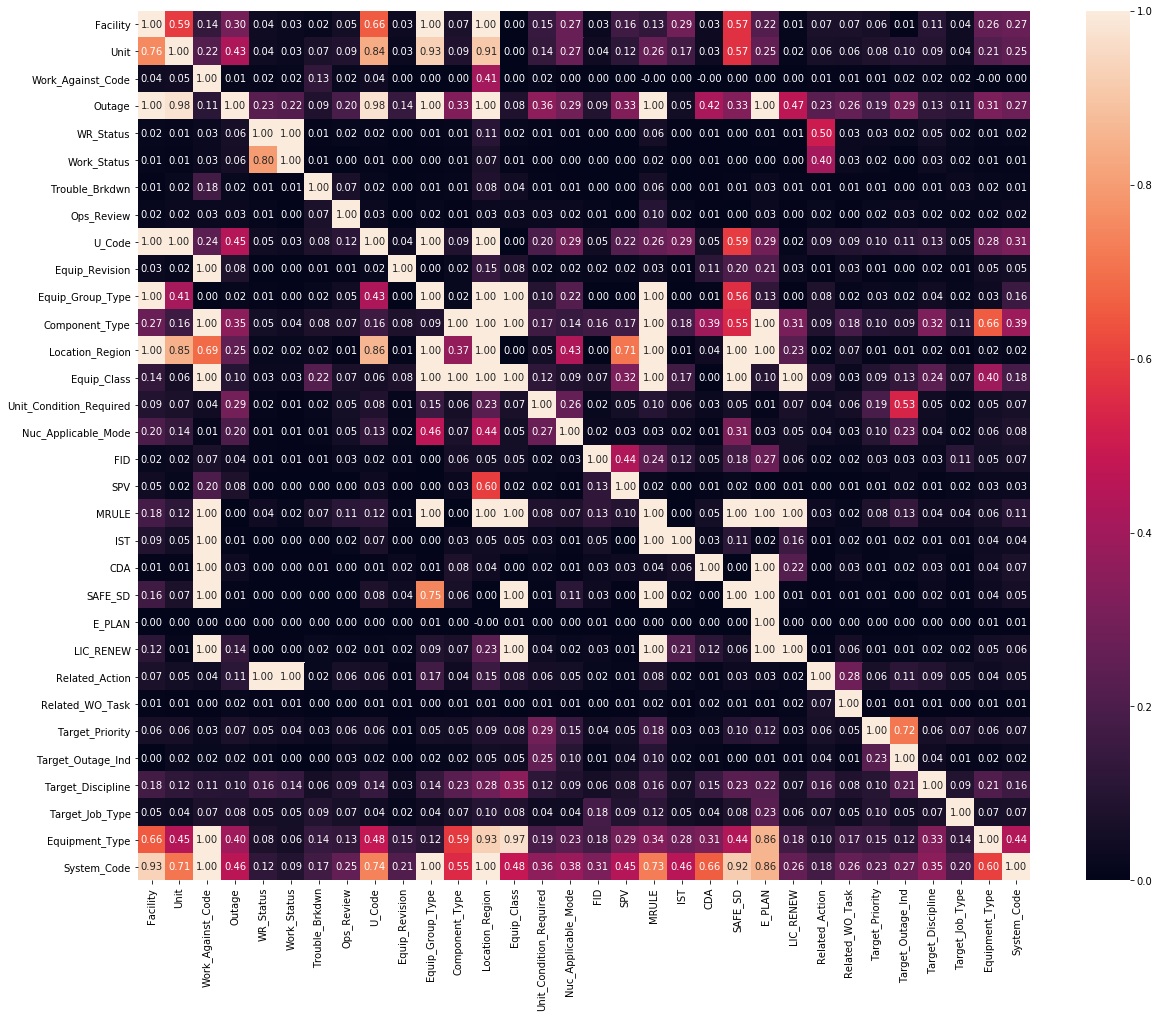

In [123]:
plt.figure(figsize=(20,16))
seaborn.heatmap(correlation_df2.fillna(value=-1), annot=True, fmt=".2f")

Now, let's do the same, but add a weighting for the fraction of non-null input values.

In [124]:
for i, icat in enumerate(cats_to_analyze):
    for j, jcat in enumerate(cats_to_analyze):
        print("Now testing", icat, jcat)
        correlation_df2[icat][jcat] = (theils_u(work_requests_train[icat], work_requests_train[jcat]) 
                                       * work_requests_train[jcat].notna().astype(int).sum()
                                       / max(work_requests_train[jcat].notna().astype(int).sum(),
                                            work_requests_train[icat].notna().astype(int).sum()))

Now testing Facility Facility
Now testing Facility Unit
Now testing Facility Work_Against_Code
Now testing Facility Outage
Now testing Facility WR_Status
Now testing Facility Work_Status
Now testing Facility Trouble_Brkdwn
Now testing Facility Ops_Review
Now testing Facility U_Code
Now testing Facility Equip_Revision
Now testing Facility Equip_Group_Type
Now testing Facility Component_Type
Now testing Facility Location_Region
Now testing Facility Equip_Class
Now testing Facility Unit_Condition_Required
Now testing Facility Nuc_Applicable_Mode
Now testing Facility FID
Now testing Facility SPV
Now testing Facility MRULE
Now testing Facility IST
Now testing Facility CDA
Now testing Facility SAFE_SD
Now testing Facility E_PLAN
Now testing Facility LIC_RENEW
Now testing Facility Related_Action
Now testing Facility Related_WO_Task
Now testing Facility Target_Priority
Now testing Facility Target_Outage_Ind
Now testing Facility Target_Discipline
Now testing Facility Target_Job_Type
Now testing

Now testing Ops_Review Component_Type
Now testing Ops_Review Location_Region
Now testing Ops_Review Equip_Class
Now testing Ops_Review Unit_Condition_Required
Now testing Ops_Review Nuc_Applicable_Mode
Now testing Ops_Review FID
Now testing Ops_Review SPV
Now testing Ops_Review MRULE
Now testing Ops_Review IST
Now testing Ops_Review CDA
Now testing Ops_Review SAFE_SD
Now testing Ops_Review E_PLAN
Now testing Ops_Review LIC_RENEW
Now testing Ops_Review Related_Action
Now testing Ops_Review Related_WO_Task
Now testing Ops_Review Target_Priority
Now testing Ops_Review Target_Outage_Ind
Now testing Ops_Review Target_Discipline
Now testing Ops_Review Target_Job_Type
Now testing Ops_Review Equipment_Type
Now testing Ops_Review System_Code
Now testing U_Code Facility
Now testing U_Code Unit
Now testing U_Code Work_Against_Code
Now testing U_Code Outage
Now testing U_Code WR_Status
Now testing U_Code Work_Status
Now testing U_Code Trouble_Brkdwn
Now testing U_Code Ops_Review
Now testing U_Code

Now testing Unit_Condition_Required Work_Status
Now testing Unit_Condition_Required Trouble_Brkdwn
Now testing Unit_Condition_Required Ops_Review
Now testing Unit_Condition_Required U_Code
Now testing Unit_Condition_Required Equip_Revision
Now testing Unit_Condition_Required Equip_Group_Type
Now testing Unit_Condition_Required Component_Type
Now testing Unit_Condition_Required Location_Region
Now testing Unit_Condition_Required Equip_Class
Now testing Unit_Condition_Required Unit_Condition_Required
Now testing Unit_Condition_Required Nuc_Applicable_Mode
Now testing Unit_Condition_Required FID
Now testing Unit_Condition_Required SPV
Now testing Unit_Condition_Required MRULE
Now testing Unit_Condition_Required IST
Now testing Unit_Condition_Required CDA
Now testing Unit_Condition_Required SAFE_SD
Now testing Unit_Condition_Required E_PLAN
Now testing Unit_Condition_Required LIC_RENEW
Now testing Unit_Condition_Required Related_Action
Now testing Unit_Condition_Required Related_WO_Task
No

Now testing SAFE_SD Equipment_Type
Now testing SAFE_SD System_Code
Now testing E_PLAN Facility
Now testing E_PLAN Unit
Now testing E_PLAN Work_Against_Code
Now testing E_PLAN Outage
Now testing E_PLAN WR_Status
Now testing E_PLAN Work_Status
Now testing E_PLAN Trouble_Brkdwn
Now testing E_PLAN Ops_Review
Now testing E_PLAN U_Code
Now testing E_PLAN Equip_Revision
Now testing E_PLAN Equip_Group_Type
Now testing E_PLAN Component_Type
Now testing E_PLAN Location_Region
Now testing E_PLAN Equip_Class
Now testing E_PLAN Unit_Condition_Required
Now testing E_PLAN Nuc_Applicable_Mode
Now testing E_PLAN FID
Now testing E_PLAN SPV
Now testing E_PLAN MRULE
Now testing E_PLAN IST
Now testing E_PLAN CDA
Now testing E_PLAN SAFE_SD
Now testing E_PLAN E_PLAN
Now testing E_PLAN LIC_RENEW
Now testing E_PLAN Related_Action
Now testing E_PLAN Related_WO_Task
Now testing E_PLAN Target_Priority
Now testing E_PLAN Target_Outage_Ind
Now testing E_PLAN Target_Discipline
Now testing E_PLAN Target_Job_Type
Now 

Now testing Target_Discipline E_PLAN
Now testing Target_Discipline LIC_RENEW
Now testing Target_Discipline Related_Action
Now testing Target_Discipline Related_WO_Task
Now testing Target_Discipline Target_Priority
Now testing Target_Discipline Target_Outage_Ind
Now testing Target_Discipline Target_Discipline
Now testing Target_Discipline Target_Job_Type
Now testing Target_Discipline Equipment_Type
Now testing Target_Discipline System_Code
Now testing Target_Job_Type Facility
Now testing Target_Job_Type Unit
Now testing Target_Job_Type Work_Against_Code
Now testing Target_Job_Type Outage
Now testing Target_Job_Type WR_Status
Now testing Target_Job_Type Work_Status
Now testing Target_Job_Type Trouble_Brkdwn
Now testing Target_Job_Type Ops_Review
Now testing Target_Job_Type U_Code
Now testing Target_Job_Type Equip_Revision
Now testing Target_Job_Type Equip_Group_Type
Now testing Target_Job_Type Component_Type
Now testing Target_Job_Type Location_Region
Now testing Target_Job_Type Equip_Cl

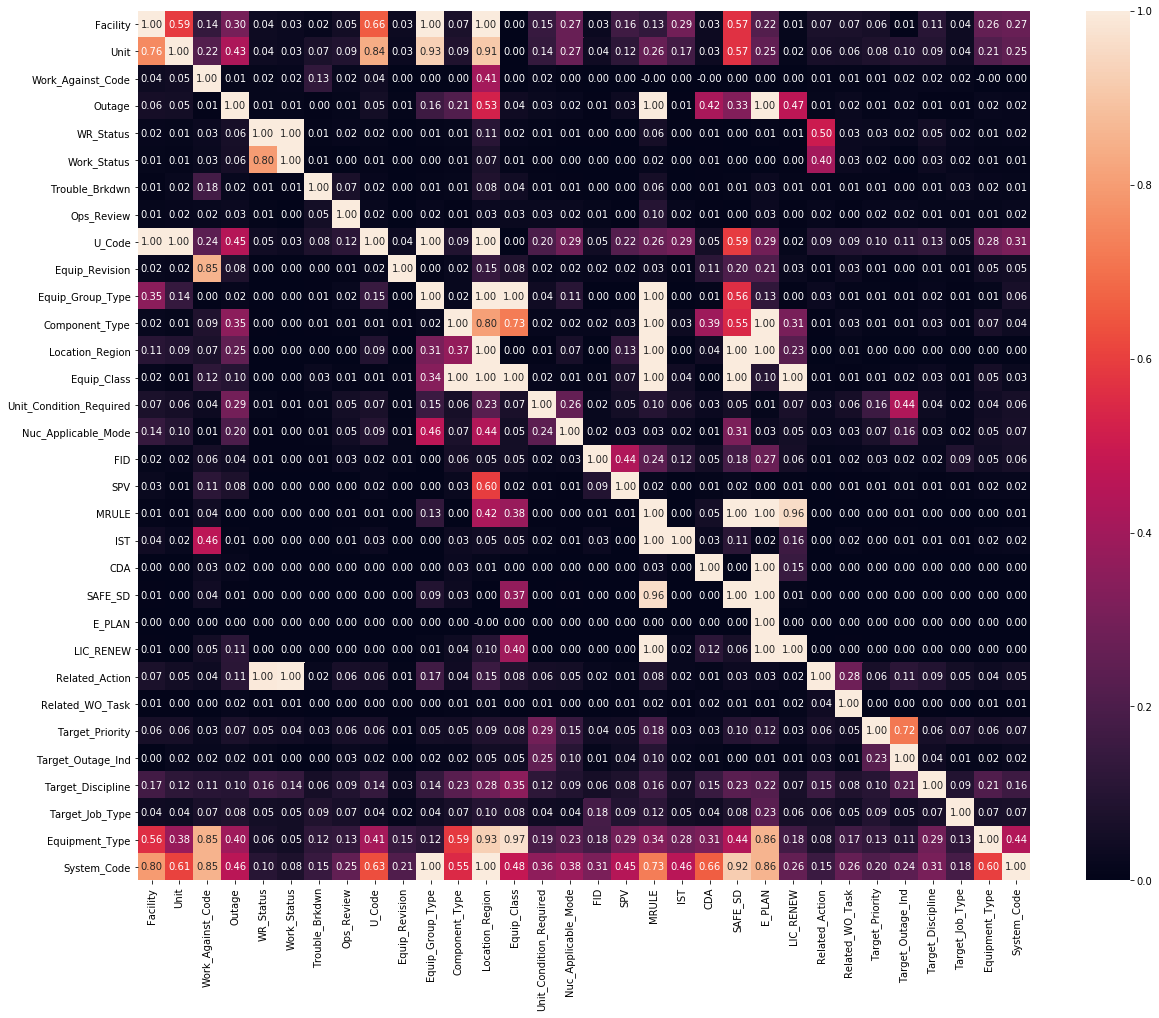

In [125]:
plt.figure(figsize=(20,16))
seaborn.heatmap(correlation_df2.fillna(value=-1), annot=True, fmt=".2f")

We can now take the 

In [126]:
correlation_df2["Target_Priority"].sort_values(ascending=False)

Target_Priority                      1
Target_Outage_Ind             0.228485
System_Code                   0.204066
Unit_Condition_Required       0.157494
Equipment_Type                 0.13305
Target_Discipline             0.101916
U_Code                        0.101385
Target_Job_Type              0.0915975
Unit                         0.0808493
Nuc_Applicable_Mode           0.074182
Related_Action               0.0647577
Facility                     0.0622125
FID                          0.0259381
WR_Status                    0.0250239
Work_Status                  0.0180681
Ops_Review                   0.0169048
Trouble_Brkdwn               0.0114254
Equip_Class                   0.011027
Outage                       0.0106251
Equip_Group_Type            0.00919476
Component_Type              0.00877633
Work_Against_Code           0.00707865
Equip_Revision               0.0065183
SPV                         0.00595899
IST                         0.00421056
Related_WO_Task          

Based on a combination of expert input and this evaluation, we will try as our inputs for priority prediction...
System_Code, Unit_Condition_Required, Equipment_Type, U_Code, Nuc_Applicable_Mode, Facility, FID, SPV, MRULE

In [127]:
correlation_df2["Target_Discipline"].sort_values(ascending=False)

Target_Discipline                    1
System_Code                   0.305188
Equipment_Type                 0.28614
U_Code                        0.131655
Facility                      0.106046
Unit                         0.0939317
Related_Action               0.0929533
Target_Job_Type              0.0660111
Target_Priority              0.0597376
WR_Status                    0.0475934
Target_Outage_Ind            0.0398566
Unit_Condition_Required      0.0369204
Work_Status                  0.0340501
Equip_Class                  0.0285641
Component_Type               0.0279784
Nuc_Applicable_Mode          0.0259633
FID                          0.0201228
Work_Against_Code            0.0177278
Equip_Group_Type             0.0159886
Ops_Review                   0.0137437
Equip_Revision               0.0135319
Trouble_Brkdwn               0.0129741
Outage                      0.00753936
IST                         0.00637114
SPV                         0.00619224
Related_WO_Task          

Based on a combination of expert input and this evaluation, we will try as our inputs for discipline prediction...
System_Code, Unit_Condition_Required, Equipment_Type, U_Code, Nuc_Applicable_Mode, Facility, FID, SPV, MRULE, Equip_Class, Component_Type

In [128]:
correlation_df2["Target_Outage_Ind"].sort_values(ascending=False)

Target_Outage_Ind                    1
Target_Priority               0.718736
Unit_Condition_Required       0.436575
System_Code                   0.235086
Target_Discipline             0.212448
Nuc_Applicable_Mode           0.164203
Related_Action                0.113945
U_Code                        0.109676
Equipment_Type                0.105829
Unit                         0.0990087
Target_Job_Type              0.0465461
FID                          0.0224179
Ops_Review                   0.0223757
WR_Status                    0.0210519
Work_Against_Code            0.0179855
Outage                       0.0165516
Equip_Class                  0.0161453
SPV                          0.0139034
IST                         0.00876367
Component_Type              0.00806941
Facility                    0.00779569
Equip_Group_Type             0.0074152
MRULE                       0.00614137
Trouble_Brkdwn              0.00437383
Related_WO_Task              0.0031283
Equip_Revision           

Based on a combination of expert input and this evaluation, we will try as our inputs for Outage_Ind prediction...
System_Code, Unit_Condition_Required, Equipment_Type, U_Code, Nuc_Applicable_Mode, FID, SPV, MRULE, Ops_Review

Let's look closer at Related_Action...

In [7]:
work_requests_train["Related_Action"].value_counts().head()

W/O COMPLETION          16673
COMPLETE MINOR W/R      14881
ASSEMBLED WR            11015
GENERATE MINOR W/R       2058
ASSOCIATED WO COMPLT     1487
Name: Related_Action, dtype: int64

Alas, related action seems to have information in it which comes after the screening process.  It cannot be included.

In [130]:
work_requests_train["Ops_Review"].value_counts().head()

Y    27194
N     7754
-        7
Name: Ops_Review, dtype: int64

Ops Review is a property of equipment, so it should be valid to use for screening!

In [135]:
work_requests_train["EMER_LIGHT"].value_counts().head()

N    99
Y    27
Name: EMER_LIGHT, dtype: int64

Not enough EMER_LIGHT cases to be worth using.

### Actually do some modeling

In [8]:
categories_to_use = ["Facility", 
                     "U_Code", 
                     "System_Code", 
                     "Unit_Condition_Required", 
                     "Equipment_Type", 
                     "U_Code", 
                     "Nuc_Applicable_Mode", 
                     "FID", 
                     "SPV", 
                     "MRULE",
                     "Component_Type",
                     "Equip_Class",
                     "Nuc_Applicable_Mode",
                     "Ops_Review",
                    ]
additional_categories = ["Target_Priority", "Target_Discipline", "Target_Outage_Ind", "Target_Job_Type"]

Excellent!  Now we have several categorical objects to encode.  We'll plan on using one-hot encoding in the actual ML, but we can integer encode for storing the information.  Note that we also need to one-hot encode the targets!

In [9]:
def GetOneHotEncoderDecoder(data_series, min_entries = 5, max_values = 500, sufficient_frac = 0.99):
    # Analyze the data, create a one-hot-style encoding so that we include no 
    # categories with fewer than 5 entries, and, if possible, at least 99% of all categories
    # We will be treating blanks, NA, nan, etc. as the same thing, the "other" category.
    encode_dict = {}
    decode_dict = {}
    vc_series = data_series.value_counts(dropna=True)
    total_counts = vc_series.sum()
    for i, (val, count) in enumerate(vc_series.items()):
        # start by checking max-value and min_entries conditions
        if i > max_values-1:
            break
        if count < 5:
            break
        encode_dict[val] = i
        decode_dict[i] = val
        # check for the 99% thing at the very end
        if vc_series.cumsum()[i]/total_counts > sufficient_frac:
            break
    # Now make an other category and a null category!
    list_len_wo_other = len(list(encode_dict))
    if "---OTHER---" not in list(encode_dict):
        encode_dict["---OTHER---"] = list_len_wo_other
        decode_dict[list_len_wo_other] = "---OTHER---"
    else:
        print("Somehow, '---OTHER---' is already a category")
    if "---NULL---" not in list(encode_dict):
        encode_dict["---NULL---"] = list_len_wo_other +1
        decode_dict[list_len_wo_other + 1] = "---NULL---"
    else:
        print("Somehow, '---NULL---' is already a category")
    return (encode_dict, decode_dict)

We're going to need all possible training and validation values...

In [10]:
wrdf_merged = pd.concat((work_requests_train, work_requests_val), axis=0)
wrdf_merged.shape

(59561, 64)

In [11]:
list(wrdf_merged)

['Work_Request_Number',
 'Facility',
 'Unit',
 'WR_Enter_Date',
 'Description',
 'Description_Code',
 'Work_Against_Code',
 'Priority',
 'Job_Type',
 'Outage_Ind',
 'Outage',
 'Need_Date',
 'WR_Status',
 'Work_Status',
 'Discipline',
 'Trouble_Brkdwn',
 'Ops_Review',
 'R_Code',
 'U_Code',
 'E_CODE',
 'Equipment_Type',
 'Equipment_Number',
 'Equipment_Name',
 'Equip_Revision',
 'Equip_Group_Type',
 'Equip_Group_ID',
 'Component_Type',
 'Component_Number',
 'Equip_UTC_Number',
 'Location_Desc',
 'Location_Region',
 'Location_ID',
 'System_Code',
 'Equip_Class',
 'Deficiency_Tag_ID',
 'Deficiency_Tag_Loc',
 'Unit_Condition_Required',
 'Nuc_Applicable_Mode',
 'Detailed_Description',
 'WO_REQ_NUMBER',
 'FID',
 'AR_Number',
 'SPV',
 'MRULE',
 'IST',
 'CDA',
 'SAFE_SD',
 'E_PLAN',
 'FIRE_PROT',
 'FIRE_PROT2',
 'APPR_FIRE',
 'FLEX',
 'EMER_LIGHT',
 'LIC_RENEW',
 'Related_Action',
 'Related_Work_Order',
 'Related_WO_Task',
 'WO_Priority',
 'WO_Discipline',
 'WO_Outage_Ind',
 'Target_Priority',


In [12]:
encoder_dict = {}
decoder_dict = {}
for category in (categories_to_use):
    encoder_dict[category], decoder_dict[category] = GetOneHotEncoderDecoder(wrdf_merged[category])
for category in (additional_categories):
    encoder_dict[category], decoder_dict[category] = GetOneHotEncoderDecoder(wrdf_merged[category], sufficient_frac = 1.0)

In [13]:
for ikey, idict in encoder_dict.items():
    print(ikey, len(list(idict)))

Facility 7
U_Code 13
System_Code 462
Unit_Condition_Required 20
Equipment_Type 186
Nuc_Applicable_Mode 11
FID 6
SPV 4
MRULE 4
Component_Type 39
Equip_Class 9
Ops_Review 4
Target_Priority 12
Target_Discipline 47
Target_Outage_Ind 4
Target_Job_Type 39


In [14]:
encoder_dict["Target_Priority"]

{'C': 0,
 'D': 1,
 '2': 2,
 'B2': 3,
 '1': 4,
 'B1': 5,
 'E': 6,
 '3': 7,
 'A': 8,
 '4': 9,
 '---OTHER---': 10,
 '---NULL---': 11}

Excellent!  We now have our encoding/decoding dictionaries, and can start making our datasets.

In [15]:
def NumberEncodeVal(category, val):
    if not val:
        return encoder_dict[category]["---NULL---"]
    elif val in (list(encoder_dict[category])):
        return encoder_dict[category][val]
    else:
        return encoder_dict[category]["---OTHER---"]

In [16]:
for category in list(encoder_dict):
    print("Now working on ", category)
    work_requests_train[category + "_enc"] = work_requests_train.apply(lambda row: NumberEncodeVal(category, row[category]), axis=1)
    work_requests_val[category + "_enc"] = work_requests_val.apply(lambda row: NumberEncodeVal(category, row[category]), axis=1)

Now working on  Facility
Now working on  U_Code
Now working on  System_Code
Now working on  Unit_Condition_Required
Now working on  Equipment_Type
Now working on  Nuc_Applicable_Mode
Now working on  FID
Now working on  SPV
Now working on  MRULE
Now working on  Component_Type
Now working on  Equip_Class
Now working on  Ops_Review
Now working on  Target_Priority
Now working on  Target_Discipline
Now working on  Target_Outage_Ind
Now working on  Target_Job_Type


In [141]:
work_requests_train.head()

,Work_Request_Number,Facility,Unit,WR_Enter_Date,Description,Description_Code,Work_Against_Code,Priority,Job_Type,Outage_Ind,...,FID_enc,SPV_enc,MRULE_enc,Component_Type_enc,Equip_Class_enc,Ops_Review_enc,Target_Priority_enc,Target_Discipline_enc,Target_Outage_Ind_enc,Target_Job_Type_enc
1,94088801,PB,0,20140102,ST-109B / CHECK VALVE BACKLEAKAGE,None,E,C,DL,N,...,1,0,3,38,8,0,0,2,0,0
2,94088802,PB,0,20140102,MISC / GROUNDWIRE NOT ATTACHED TO SOUTH FENCE ...,None,N,C,DL,N,...,5,3,3,38,8,1,0,5,0,0
3,94088803,PB,0,20140102,FT-03298B /PAB VENT STACK ISOKINETIC FLOW XMIT...,None,E,C,DL,N,...,0,0,3,38,8,0,0,1,0,0
5,94088805,PB,0,20140102,LS-4125 / OPERATION REQUIRES OPTIMIZATION,None,E,C,DL,N,...,1,0,3,38,8,0,0,2,0,0
7,94088808,PTN,04,20140102,4A HDP FILTERS REPLACEMENT,None,E,C,DL,N,...,2,1,3,38,8,3,0,5,0,0


In [142]:
work_requests_val.head()

,Work_Request_Number,Facility,Unit,WR_Enter_Date,Description,Description_Code,Work_Against_Code,Priority,Job_Type,Outage_Ind,...,FID_enc,SPV_enc,MRULE_enc,Component_Type_enc,Equip_Class_enc,Ops_Review_enc,Target_Priority_enc,Target_Discipline_enc,Target_Outage_Ind_enc,Target_Job_Type_enc
0,94088798,SEA,1,20140102,ADMIN BUILDING DOOR A128 DOOR KNOB IS LOOSE,None,E,C,DN,N,...,0,3,3,38,3,3,0,7,0,2
4,94088804,PSL,01,20140102,IMPORTANT BARRIER TO SAFETY DOOR #149 HAS BROK...,None,N,C,DL,N,...,5,3,3,38,8,0,3,2,0,0
6,94088807,PTN,03,20140102,GRIZZLY RAKE BROKEN WELD (AR 1930242),None,N,B2,CL,N,...,5,3,3,38,8,0,3,0,0,4
9,94088810,PSL,00,20140102,DOOR 251 STRIKE IS NOT WORKING PROPERLY,None,N,None,DL,N,...,5,3,3,38,8,3,3,8,0,0
14,94088818,PB,2,20140102,"2X-11 / MINOR ""SEEPAGE"" NOTED AT 2X-11",None,E,2,DL,Y,...,2,0,3,38,8,0,2,3,1,0


In [143]:
# Check ---OTHER--- fractions
total_wrs = work_requests_train.shape[0]
for category in list(encoder_dict):
    cat_enc = category + "_enc"
    print(category, (work_requests_train[cat_enc].apply(lambda x: decoder_dict[category][x])=="---OTHER---").astype(int).sum()/total_wrs)

Facility 0.0
U_Code 0.004827369083849302
System_Code 0.008626298667226362
Unit_Condition_Required 0.0074299506768811
Equipment_Type 0.008269493126246195
Nuc_Applicable_Mode 0.006716339594920768
FID 0.00016790848987301922
SPV 0.0
MRULE 0.0
Component_Type 0.0006716339594920769
Equip_Class 0.0
Ops_Review 0.0001469199286388918
Target_Priority 2.0988561234127402e-05
Target_Discipline 0.0009234966943016057
Target_Outage_Ind 0.0
Target_Job_Type 0.000839542449365096


In [144]:
# Check ---NULL--- fractions
total_wrs = work_requests_train.shape[0]
for category in list(encoder_dict):
    cat_enc = category + "_enc"
    print(category, (work_requests_train[cat_enc].apply(lambda x: decoder_dict[category][x])=="---NULL---").astype(int).sum()/total_wrs)

Facility 0.0
U_Code 4.1977122468254804e-05
System_Code 0.1472137684961696
Unit_Condition_Required 0.20058767971455557
Equipment_Type 0.1472137684961696
Nuc_Applicable_Mode 0.29350404029803756
FID 0.23771644453772695
SPV 0.4384510441809214
MRULE 0.9550425018364991
Component_Type 0.9143666701647603
Equip_Class 0.8820862629866723
Ops_Review 0.2663448420610767
Target_Priority 0.021408332458809947
Target_Discipline 0.023318291531115542
Target_Outage_Ind 0.02325532584741316
Target_Job_Type 0.0631965578759576


We still have ~2% null type on target priority, discipline, and outage indicator.  Those should probably get taken out, but I'll worry about that later.

## Create X and Y data arrays

Let's write this in such a way that it is easy to change which variables we use

In [17]:
for category in list(encoder_dict):
    print("Now working on ", category)
    work_requests_train[category + "_enc"] = work_requests_train.apply(lambda row: NumberEncodeVal(category, row[category]), axis=1)
    work_requests_val[category + "_enc"] = work_requests_val.apply(lambda row: NumberEncodeVal(category, row[category]), axis=1)
    

Now working on  Facility
Now working on  U_Code
Now working on  System_Code
Now working on  Unit_Condition_Required
Now working on  Equipment_Type
Now working on  Nuc_Applicable_Mode
Now working on  FID
Now working on  SPV
Now working on  MRULE
Now working on  Component_Type
Now working on  Equip_Class
Now working on  Ops_Review
Now working on  Target_Priority
Now working on  Target_Discipline
Now working on  Target_Outage_Ind
Now working on  Target_Job_Type


In [18]:
def DataFrameToXY(dataframe, X_categories = categories_to_use, Y_category = "Priority"):
    # Yes, this is a lot of looping, but we don't need to do this often
    X_catlens = [len(list(encoder_dict[cat])) for cat in X_categories]
    Y_catlen = len(list(encoder_dict[Y_category]))
    X_shape = (dataframe.shape[0], int(np.sum(X_catlens)))
    Y_shape = (dataframe.shape[0], int(np.sum(Y_catlen)))

    Y_index_array = np.array(dataframe[str(Y_category + "_enc")])
    Y_oh_array = np.zeros(Y_shape)
    Y_oh_array[np.arange(Y_shape[0]), Y_index_array] = 1
    Y = Y_oh_array

    X_oh_list = []
    for X_cat, X_len in zip(X_categories, X_catlens):
        X_index_array = np.array(dataframe[str(X_cat + "_enc")])
        X_oh_array = np.zeros((X_shape[0], X_len))
        X_oh_array[np.arange(X_shape[0]), X_index_array] = 1
        X_oh_list.append(X_oh_array)
    X = np.concatenate(X_oh_list, axis=1)
    return X, Y

In [19]:
X_train_pri, Y_train_pri = DataFrameToXY(work_requests_train, X_categories = categories_to_use, Y_category = "Target_Priority")
X_val_pri, Y_val_pri = DataFrameToXY(work_requests_val, X_categories = categories_to_use, Y_category = "Target_Priority")

In [20]:
X_train_pri.shape, X_val_pri.shape

((47645, 789), (11916, 789))

## Build the MLP Model

We'll use an MLP for this.  The input layer will have 789 inputs, and the output layer 12 which we'll softmax.

We can start with two hidden layers.  We like the idea of using two because that should be enough to get a little non-linearity, but not so much that we get a lot of deep learning problems.  Current plan for shape:

input input_shape

hidden 1 128

hidden 2 64

output 12-> softmax

In [21]:
from keras.metrics import top_k_categorical_accuracy
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [22]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_pri.shape[1], activation='tanh', kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dense(64, input_dim=128, activation='tanh', kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dense(Y_train_pri.shape[1], input_dim=64, activation='softmax', kernel_regularizer=regularizers.l2(0.0002)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', top_3_categorical_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               101120    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 110,156
Trainable params: 110,156
Non-trainable params: 0
_________________________________________________________________
None


## Train and validate the MLP model

In [23]:
batch_size = 256
num_epochs = 50

kerasbackend.set_value(model.optimizer.lr, 0.001)
tgt_priority_mdl_history = model.fit(X_train_pri,
          Y_train_pri,
          batch_size = batch_size,
          epochs = num_epochs,
          validation_data = (X_val_pri, Y_val_pri)
         )

Train on 47645 samples, validate on 11916 samples
Epoch 1/50
47645/47645 [==============================] - 2s 33us/step - loss: 1.3087 - categorical_accuracy: 0.5833 - top_3_categorical_accuracy: 0.8736 - val_loss: 1.1765 - val_categorical_accuracy: 0.6103 - val_top_3_categorical_accuracy: 0.9066
Epoch 2/50
47645/47645 [==============================] - 1s 19us/step - loss: 1.1475 - categorical_accuracy: 0.6189 - top_3_categorical_accuracy: 0.9115 - val_loss: 1.1488 - val_categorical_accuracy: 0.6168 - val_top_3_categorical_accuracy: 0.9107
Epoch 3/50
47645/47645 [==============================] - 1s 18us/step - loss: 1.1305 - categorical_accuracy: 0.6214 - top_3_categorical_accuracy: 0.9143 - val_loss: 1.1433 - val_categorical_accuracy: 0.6203 - val_top_3_categorical_accuracy: 0.9095
Epoch 4/50
47645/47645 [==============================] - 1s 17us/step - loss: 1.1234 - categorical_accuracy: 0.6234 - top_3_categorical_accuracy: 0.9159 - val_loss: 1.1386 - val_categorical_accuracy: 0.

Epoch 34/50
47645/47645 [==============================] - 1s 19us/step - loss: 1.0786 - categorical_accuracy: 0.6312 - top_3_categorical_accuracy: 0.9220 - val_loss: 1.1179 - val_categorical_accuracy: 0.6255 - val_top_3_categorical_accuracy: 0.9152
Epoch 35/50
47645/47645 [==============================] - 1s 17us/step - loss: 1.0778 - categorical_accuracy: 0.6313 - top_3_categorical_accuracy: 0.9226 - val_loss: 1.1225 - val_categorical_accuracy: 0.6229 - val_top_3_categorical_accuracy: 0.9156
Epoch 36/50
47645/47645 [==============================] - 1s 18us/step - loss: 1.0774 - categorical_accuracy: 0.6308 - top_3_categorical_accuracy: 0.9226 - val_loss: 1.1211 - val_categorical_accuracy: 0.6226 - val_top_3_categorical_accuracy: 0.9127
Epoch 37/50
47645/47645 [==============================] - 1s 18us/step - loss: 1.0772 - categorical_accuracy: 0.6316 - top_3_categorical_accuracy: 0.9224 - val_loss: 1.1248 - val_categorical_accuracy: 0.6230 - val_top_3_categorical_accuracy: 0.9158


### Plot Training and Validation Loss

In [61]:
def plot_train_val_loss(model_history, title="Model loss"):
    """Plot training & validation loss values for a trained Keras model
    
    Parameters
    ----------
    model_history: keras.callbacks.History
        The History object returned by the fit() method of a Keras Model
    
    Returns
    -------
    None    
    """
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

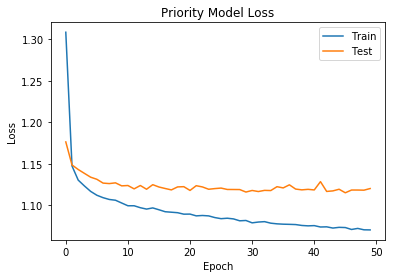

In [62]:
plot_train_val_loss(tgt_priority_mdl_history, "Priority Model Loss")

In [37]:
pred_val_pri = (model.predict(X_val_pri))

In [38]:
pred_val_pri.shape

(11916, 12)

In [39]:
pred_val_pri_indices = [decoder_dict["Target_Priority"][np.argmax(row)] for row in pred_val_pri]

In [40]:
Counter(pred_val_pri_indices)

Counter({'C': 7906,
         '2': 1526,
         'D': 1723,
         '---NULL---': 135,
         'E': 93,
         'B2': 312,
         '1': 211,
         'B1': 10})

In [162]:
true_val_pri_indices = [decoder_dict["Target_Priority"][np.argmax(row)] for row in Y_val_pri]

In [163]:
Counter(true_val_pri_indices)

Counter({'C': 5762,
         'B2': 769,
         '2': 1390,
         '---NULL---': 251,
         'D': 2513,
         'B1': 325,
         'E': 213,
         '3': 166,
         '1': 461,
         'A': 57,
         '4': 9})

Seems like it got to 62% accuracy, and then stopped.  That's certainly improved over last time, maybe there's more that can be done.

### Do the precision/recall calculations

In [49]:
def GetPrecisionRecall(y_pred, y_true):
    cm_labels = list(set(y_true).union(y_pred))
    cm = confusion_matrix(y_true, y_pred, cm_labels)
    cm_label_recall = recall_score(y_true, y_pred, labels=cm_labels, average=None)
    cm_label_recall = pd.DataFrame(cm_label_recall, index=cm_labels, columns=['Recall'])
    cm_label_precision = precision_score(y_true, y_pred, labels=cm_labels, average=None)
    cm_label_precision = pd.DataFrame(cm_label_precision, index=cm_labels, columns=['Precision'])
    cm_label_f1 = f1_score(y_true, y_pred, labels=cm_labels, average=None)
    cm_label_f1 = pd.DataFrame(cm_label_f1, index=cm_labels, columns=['F1'])
    
    true_label_cts = pd.Series(y_true).value_counts(dropna=False).to_frame('Number in Validation Set')
    predicted_label_cts = pd.Series(y_pred).value_counts(dropna=False).to_frame('Predicted Num in Validation Set')
    
    model_metrics = cm_label_precision.join(cm_label_recall).join(cm_label_f1).join(true_label_cts).join(predicted_label_cts)
    return model_metrics

In [216]:
df_eval_pri = GetPrecisionRecall(pred_val_pri_indices, true_val_pri_indices)

/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [217]:
df_eval_pri

,Precision,Recall,F1,Number in Validation Set,Predicted Num in Validation Set
A,0.000000,0.000000,0.000000,57,NaN
2,0.653047,0.655396,0.654219,1390,1395.0
1,0.534810,0.366594,0.435006,461,316.0
4,0.000000,0.000000,0.000000,9,NaN
3,0.333333,0.006024,0.011834,166,3.0
B1,0.478261,0.033846,0.063218,325,23.0
C,0.633173,0.889101,0.739623,5762,8091.0
E,0.523810,0.154930,0.239130,213,63.0
---NULL---,0.428571,0.227092,0.296875,251,133.0
B2,0.527660,0.161248,0.247012,769,235.0


In [220]:
weighted_mean_f1_pri = (df_eval_pri["F1"] * df_eval_pri["Number in Validation Set"]).sum()/df_eval_pri["Number in Validation Set"].sum()
weighted_mean_f1_pri

0.5864654156860362

## Trying a Random Forest model

Let's test out some random forest model parameters

In [178]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

The final classes should not be one-hot vectors, but single numbers!  Thats how the random forest model will work.  Let's try with several types of forests.

In [179]:
def RunRandomForest(X_train, Y_train, X_val, Y_val, num_trees = 100):
    # Convert from one-hot Y to categorical Y
    Y_train_class = np.dot(Y_train,(np.array([1,2,3,4,5,6,7,8,9,10,11,12])))
    Y_val_class = np.dot(Y_val,(np.array([1,2,3,4,5,6,7,8,9,10,11,12])))
    
    # random forest model creation
    t0 = time.time()
    rfc = RandomForestClassifier(n_estimators = num_trees)
    rfc.fit(X_train, Y_train_class)
    rfc_predict = rfc.predict(X_val)
    rfc_predict_train = rfc.predict(X_train)
    t1 = time.time()
    print("Ran random forest with ", num_trees, " trees in ", t1-t0, " seconds.")
    print("Train Accuracy: ", (Y_train_class == rfc_predict_train).astype(int).sum()/len(Y_train_class))
    print("Validation Accuracy: ", (Y_val_class == rfc_predict).astype(int).sum()/len(Y_val_class))
    return rfc


In [184]:
rfc10 = RunRandomForest(X_train_pri, Y_train_pri, X_val_pri, Y_val_pri, num_trees = 10)

Ran random forest with  10  trees in  3.5674796104431152  seconds.
Train Accuracy:  0.7731766187427852
Validation Accuracy:  0.6101040617656932


In [185]:
rfc20 = RunRandomForest(X_train_pri, Y_train_pri, X_val_pri, Y_val_pri, num_trees = 20)

Ran random forest with  20  trees in  6.52698826789856  seconds.
Train Accuracy:  0.7790324273271068
Validation Accuracy:  0.6116985565626049


In [186]:
rfc50 = RunRandomForest(X_train_pri, Y_train_pri, X_val_pri, Y_val_pri, num_trees = 50)

Ran random forest with  50  trees in  16.15957760810852  seconds.
Train Accuracy:  0.781215237695456
Validation Accuracy:  0.6200067136623028


In [187]:
rfc4 = RunRandomForest(X_train_pri, Y_train_pri, X_val_pri, Y_val_pri, num_trees = 4)

Ran random forest with  4  trees in  1.414961338043213  seconds.
Train Accuracy:  0.7532164970091301
Validation Accuracy:  0.596592816381336


In [198]:
np.unique(rfc50.predict(X_val_pri), return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12.]),
 array([7303, 2071, 1310,  427,  345,  116,  125,   68,   17,  134]))

In [200]:
[decoder_dict["Target_Priority"][row-1] for row in rfc50.predict(X_val_pri)]

['C',
 'C',
 'C',
 'C',
 '2',
 'C',
 'C',
 'C',
 'B2',
 'C',
 'D',
 'C',
 'C',
 'D',
 'C',
 'C',
 'C',
 'C',
 'C',
 '2',
 'C',
 'C',
 'C',
 'C',
 'C',
 '2',
 'D',
 'C',
 'C',
 'D',
 'C',
 'C',
 'D',
 'C',
 'B2',
 'C',
 'C',
 'D',
 'D',
 'D',
 'C',
 'C',
 '3',
 'C',
 'C',
 'C',
 'D',
 'C',
 '2',
 'C',
 'C',
 'C',
 'C',
 'B1',
 'B1',
 'C',
 'D',
 '2',
 'C',
 'B1',
 'D',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'D',
 'D',
 'C',
 'C',
 'B1',
 'C',
 'C',
 'C',
 'C',
 'D',
 'C',
 'C',
 '---NULL---',
 'C',
 'C',
 'C',
 'C',
 'B2',
 'D',
 'B2',
 'C',
 'C',
 'C',
 '2',
 'D',
 'C',
 'D',
 'C',
 'D',
 'D',
 'C',
 'C',
 'D',
 'D',
 'C',
 'D',
 'C',
 'C',
 '2',
 'D',
 'C',
 'C',
 'C',
 'C',
 'D',
 'D',
 'C',
 'C',
 'C',
 'C',
 'B2',
 'E',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 '2',
 'D',
 'C',
 'C',
 'C',
 'C',
 'C',
 'B2',
 'D',
 'D',
 '1',
 'C',
 'C',
 '2',
 'B2',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'D',
 'D',
 'D',
 'C',
 'C',
 'C',
 'C',
 '2',
 'D',
 '

In [229]:
df_eval_forest_pri = GetPrecisionRecall([decoder_dict["Target_Priority"][row-1] for row in rfc50.predict(X_val_pri)], true_val_pri_indices)
df_eval_forest_pri

/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Precision,Recall,F1,Number in Validation Set,Predicted Num in Validation Set
A,0.058824,0.017544,0.027027,57,17.0
2,0.688550,0.648921,0.668148,1390,1310.0
1,0.513043,0.383948,0.439206,461,345.0
4,0.000000,0.000000,0.000000,9,NaN
3,0.411765,0.168675,0.239316,166,68.0
B1,0.250000,0.089231,0.131519,325,116.0
C,0.648227,0.821590,0.724684,5762,7303.0
E,0.440000,0.258216,0.325444,213,125.0
---NULL---,0.402985,0.215139,0.280519,251,134.0
B2,0.372365,0.206762,0.265886,769,427.0


In [223]:
weighted_mean_forest_f1_pri = (df_eval_forest_pri["F1"] * df_eval_forest_pri["Number in Validation Set"]).sum()/df_eval_forest_pri["Number in Validation Set"].sum()
weighted_mean_forest_f1_pri

0.5962126060170906

Always over-fitting!  Looks like performance is similar to the MLP.  It actually has a slightly higher weighted mean F1.  Interesting.

## Quick check MLP, but this time looking for discipline and outage indicator

In [41]:
X_train_dis, Y_train_dis = DataFrameToXY(work_requests_train, X_categories = categories_to_use, Y_category = "Target_Discipline")
X_val_dis, Y_val_dis = DataFrameToXY(work_requests_val, X_categories = categories_to_use, Y_category = "Target_Discipline")

In [42]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_dis.shape[1], activation='tanh', kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dense(64, input_dim=128, activation='tanh', kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dense(Y_train_dis.shape[1], input_dim=64, activation='softmax', kernel_regularizer=regularizers.l2(0.0002)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', top_3_categorical_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               101120    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 47)                3055      
Total params: 112,431
Trainable params: 112,431
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
batch_size = 256
num_epochs = 50

kerasbackend.set_value(model.optimizer.lr, 0.001)
discipline_mdl_history = model.fit(X_train_dis,
          Y_train_dis,
          batch_size = batch_size,
          epochs = num_epochs,
          validation_data = (X_val_dis, Y_val_dis)
         )

Train on 47645 samples, validate on 11916 samples
Epoch 1/50
47645/47645 [==============================] - 2s 38us/step - loss: 2.2565 - categorical_accuracy: 0.3552 - top_3_categorical_accuracy: 0.6564 - val_loss: 1.8312 - val_categorical_accuracy: 0.4511 - val_top_3_categorical_accuracy: 0.7636
Epoch 2/50
47645/47645 [==============================] - 1s 21us/step - loss: 1.7765 - categorical_accuracy: 0.4579 - top_3_categorical_accuracy: 0.7721 - val_loss: 1.7439 - val_categorical_accuracy: 0.4642 - val_top_3_categorical_accuracy: 0.7852
Epoch 3/50
47645/47645 [==============================] - 1s 21us/step - loss: 1.7139 - categorical_accuracy: 0.4709 - top_3_categorical_accuracy: 0.7860 - val_loss: 1.7111 - val_categorical_accuracy: 0.4689 - val_top_3_categorical_accuracy: 0.7927
Epoch 4/50
47645/47645 [==============================] - 1s 21us/step - loss: 1.6847 - categorical_accuracy: 0.4761 - top_3_categorical_accuracy: 0.7923 - val_loss: 1.7003 - val_categorical_accuracy: 0.

Epoch 34/50
47645/47645 [==============================] - 1s 20us/step - loss: 1.5818 - categorical_accuracy: 0.5022 - top_3_categorical_accuracy: 0.8168 - val_loss: 1.6628 - val_categorical_accuracy: 0.4839 - val_top_3_categorical_accuracy: 0.8072
Epoch 35/50
47645/47645 [==============================] - 1s 22us/step - loss: 1.5820 - categorical_accuracy: 0.5030 - top_3_categorical_accuracy: 0.8169 - val_loss: 1.6698 - val_categorical_accuracy: 0.4806 - val_top_3_categorical_accuracy: 0.8061
Epoch 36/50
47645/47645 [==============================] - 1s 19us/step - loss: 1.5822 - categorical_accuracy: 0.5026 - top_3_categorical_accuracy: 0.8166 - val_loss: 1.6615 - val_categorical_accuracy: 0.4823 - val_top_3_categorical_accuracy: 0.8080
Epoch 37/50
47645/47645 [==============================] - 1s 19us/step - loss: 1.5798 - categorical_accuracy: 0.5042 - top_3_categorical_accuracy: 0.8180 - val_loss: 1.6623 - val_categorical_accuracy: 0.4823 - val_top_3_categorical_accuracy: 0.8063


### Plot Displine Model Training and Validation Loss

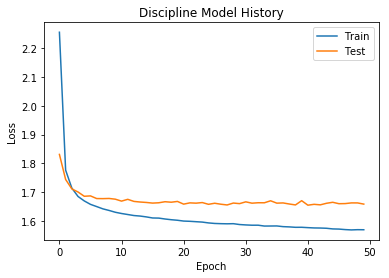

In [63]:
plot_train_val_loss(discipline_mdl_history, "Discipline Model History")

In [47]:
pred_val_dis = (model.predict(X_val_dis))
pred_val_dis_indices = [decoder_dict["Target_Discipline"][np.argmax(row)] for row in pred_val_dis]
true_val_dis_indices = [decoder_dict["Target_Discipline"][np.argmax(row)] for row in Y_val_dis]

In [50]:
df_eval_dis = GetPrecisionRecall(pred_val_dis_indices, true_val_dis_indices)
df_eval_dis

/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/data/jalbert/conda/envs/jba36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Precision,Recall,F1,Number in Validation Set,Predicted Num in Validation Set
CHEM,0.500000,0.428571,0.461538,14,12.0
TD,0.653846,0.539683,0.591304,63,52.0
CNST,1.000000,0.190476,0.320000,21,4.0
ENGD,0.000000,0.000000,0.000000,6,NaN
MECH,0.474581,0.664375,0.553665,2473,3462.0
MSS,0.574586,0.353741,0.437895,294,181.0
RW,0.000000,0.000000,0.000000,9,NaN
RP,0.000000,0.000000,0.000000,17,NaN
FP,0.000000,0.000000,0.000000,1,NaN
FIN,0.482916,0.408478,0.442589,519,439.0


In [53]:
weighted_mean_f1_dis = (df_eval_dis["F1"] * df_eval_dis["Number in Validation Set"]).sum()/df_eval_dis["Number in Validation Set"].sum()
print("Weighted Mean F1 Score: {:0.3f}".format(weighted_mean_f1_dis))

Weighted Mean F1 Score: 0.476


In [231]:
df_eval_dis.shape

(45, 5)

Looks like we can hit around 48% accuracy for discipline with these inputs...

## MLP for Outage Indicator

In [54]:
X_train_oi, Y_train_oi = DataFrameToXY(work_requests_train, X_categories = categories_to_use, Y_category = "Target_Outage_Ind")
X_val_oi, Y_val_oi = DataFrameToXY(work_requests_val, X_categories = categories_to_use, Y_category = "Target_Outage_Ind")

In [55]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_oi.shape[1], activation='tanh', kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dense(64, input_dim=128, activation='tanh', kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dense(Y_train_oi.shape[1], input_dim=64, activation='softmax', kernel_regularizer=regularizers.l2(0.0002)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', top_3_categorical_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               101120    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 109,636
Trainable params: 109,636
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
batch_size = 256
num_epochs = 50

kerasbackend.set_value(model.optimizer.lr, 0.001)
outage_mdl_history = model.fit(X_train_oi,
          Y_train_oi,
          batch_size = batch_size,
          epochs = num_epochs,
          validation_data = (X_val_oi, Y_val_oi)
         )

Train on 47645 samples, validate on 11916 samples
Epoch 1/50
47645/47645 [==============================] - 2s 43us/step - loss: 0.4174 - categorical_accuracy: 0.8792 - top_3_categorical_accuracy: 0.9986 - val_loss: 0.3690 - val_categorical_accuracy: 0.8942 - val_top_3_categorical_accuracy: 1.0000
Epoch 2/50
47645/47645 [==============================] - 1s 19us/step - loss: 0.3459 - categorical_accuracy: 0.8995 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3666 - val_categorical_accuracy: 0.8944 - val_top_3_categorical_accuracy: 1.0000
Epoch 3/50
47645/47645 [==============================] - 1s 18us/step - loss: 0.3381 - categorical_accuracy: 0.8992 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3584 - val_categorical_accuracy: 0.8943 - val_top_3_categorical_accuracy: 1.0000
Epoch 4/50
47645/47645 [==============================] - 1s 18us/step - loss: 0.3330 - categorical_accuracy: 0.9003 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3577 - val_categorical_accuracy: 0.

Epoch 34/50
47645/47645 [==============================] - 1s 17us/step - loss: 0.3080 - categorical_accuracy: 0.9023 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3392 - val_categorical_accuracy: 0.8967 - val_top_3_categorical_accuracy: 1.0000
Epoch 35/50
47645/47645 [==============================] - 1s 17us/step - loss: 0.3078 - categorical_accuracy: 0.9020 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3341 - val_categorical_accuracy: 0.8968 - val_top_3_categorical_accuracy: 1.0000
Epoch 36/50
47645/47645 [==============================] - 1s 17us/step - loss: 0.3080 - categorical_accuracy: 0.9021 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3349 - val_categorical_accuracy: 0.8958 - val_top_3_categorical_accuracy: 1.0000
Epoch 37/50
47645/47645 [==============================] - 1s 18us/step - loss: 0.3090 - categorical_accuracy: 0.9019 - top_3_categorical_accuracy: 1.0000 - val_loss: 0.3351 - val_categorical_accuracy: 0.8951 - val_top_3_categorical_accuracy: 1.0000


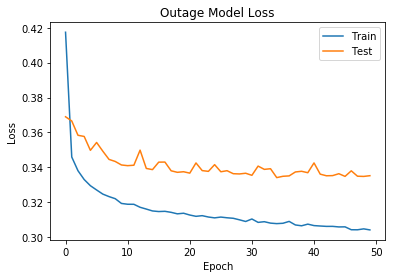

In [64]:
plot_train_val_loss(outage_mdl_history, title="Outage Model Loss")

In [58]:
pred_val_oi = (model.predict(X_val_oi))
pred_val_oi_indices = [decoder_dict["Target_Outage_Ind"][np.argmax(row)] for row in pred_val_oi]
true_val_oi_indices = [decoder_dict["Target_Outage_Ind"][np.argmax(row)] for row in Y_val_oi]

In [59]:
df_eval_oi = GetPrecisionRecall(pred_val_oi_indices, true_val_oi_indices)
df_eval_oi

,Precision,Recall,F1,Number in Validation Set,Predicted Num in Validation Set
Y,0.842010,0.667787,0.744846,2083,1652
---NULL---,1.000000,0.003279,0.006536,305,1
N,0.904024,0.973762,0.937598,9528,10263


In [60]:
weighted_mean_f1_oi = (df_eval_oi["F1"] * df_eval_oi["Number in Validation Set"]).sum()/df_eval_oi["Number in Validation Set"].sum()
print("Weighted Mean F1 Score: {:0.3f}".format(weighted_mean_f1_oi))

Weighted Mean F1 Score: 0.880


Well, 90% accuracy is pretty darned good!  And F1 scores are quite high for this too.  Outage indicator was the easiest to predict, but it seems we're doing pretty well.  And it isn't just always predicting N, it is predicting Y and N reasonably!

## Conclusions/Future work

We're up to 62%, 48%, and 90% accuracy on priority, discipline, and outage_indicator.  Definite improvement from last week, mainly due to cleaner input data, and more useful categories.

Precision, Recall, and F1 metrics have been implemented.  We can combine them into a single weighted F1 score.  Doing that, we find 58.6% for MLP Priority, 59.6% for RFC Priority, 47.5% for MLP Discipline, 88.2% for MLP Outage_Ind.  These values may be especially useful for choosing models with hyperparameter searches.

A major next step which needs to be taken is to better deal with null values.  They are supposed to be non-informative, but they aren't.

Getting business logic may help with these tasks.

A study of E_CODEs which appear in many WRs, and the correlation with the things we wish to predict may be a useful alternative model.  That's a separate investigation.